# Tree Creation
The reasons we are going to create a tree-based model  are:
* they handle categorical and numerical data
* they are able to handle non-linear relationships between features and target variables
* they provide a clear and interpretable method for feature importance

Just like a tree has a trunk and branches, a tree-based model starts with a big "trunk" of data and then branches out into different "leaves" based on certain rules.

Let's say we want to build a tree-based model to predict whether or not it's going to rain tomorrow. We start with a big trunk of data about the weather, like the temperature, humidity, and wind speed.

Then, we look at one of those pieces of data, like the temperature. We ask ourselves, "If the temperature is below 50 degrees, is it more likely to rain or not?" If we think it's more likely to rain, we create a branch that says "yes, it's going to rain" and if we think it's less likely to rain, we create a branch that says "no, it's not going to rain".

Then, we look at another piece of data, like the humidity, and create more branches based on whether or not we think it's more or less likely to rain. We keep doing this for all the different pieces of data until we have a big tree with lots of branches and leaves.

To make a tree-based model for classification, we start by looking at each column in the data and finding the best way to split it into groups based on the different labels. We create a "node" with this information and then repeat the process for each node until we have a "pure" node or a parameter tells us to stop. To know when our separation is good, we use a metric called the Gini Coefficient.
 
## 4.1 The Gini Coefficient
The Gini coefficient was proposed by Corrado Gini, an Italian statistician, in the year 1912. He originally created it as a measure of inequality of income distribution, but it has since been applied to other areas, including economics, sociology, and machine learning.

Gini was interested in understanding the distribution of wealth in society and wanted a way to quantify the degree of inequality. He developed the Gini coefficient as a way to measure this inequality on a scale of 0 to 1, where 0 represents perfect equality (everyone has the same wealth) and 1 represents perfect inequality (one person has all the wealth).

In machine learning, the Gini coefficient can help us understand the quality of the splits (or a measure of the "purity" of a node in the tree) in a tree-based model and identify the nodes that are most informative for making predictions.
When building the tree, the model splits the data into different groups based on the values of the input features, and it tries to create groups that are as "pure" as possible - that is, groups where all the samples belong to the same class or category. The score of 0 indicates that all the samples in the group belong to the same class (perfect purity) and a score of 1 indicates that the samples are evenly distributed among all the classes (maximum impurity).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rn
from EffectiveXGBoost import *

```python
pos_center = 12
pos_count = 100
neg_center = 7
neg_count = 1000
```
These four lines define four variables: `pos_center`, `pos_count`, `neg_center`, and `neg_count`. `pos_center` and `pos_count` represent the mean and number of data points for a hypothetical positive dataset, and `neg_center` and `neg_count` represent the mean and number of data points for a hypothetical negative dataset.

```python
rs = rn.RandomState(rn.MT19937(rn.SeedSequence(42)))
```
This line creates a random number generator object, `rs`, using the `RandomState` function from the `numpy.random` library. The `MT19937` function generates random numbers using the Mersenne Twister algorithm, and `SeedSequence(42)` sets the initial seed for the random number generator.

```python
gini = pd.DataFrame({'value':
np.append((pos_center) + rs.randn(pos_count),
(neg_center) + rs.randn(neg_count)),
'label':
['pos']* pos_count + ['neg'] * neg_count})

```
This line creates a Pandas DataFrame called `gini`. The DataFrame has two columns: `value` and `label`. The `value` column is created by appending two arrays of random numbers to each other using `np.append()`. The first array is generated by adding `pos_center` to an array of `pos_count` random numbers generated using `rs.randn()`. The second array is generated by adding `neg_center` to an array of `neg_count` random numbers generated using `rs.randn()`. The label column is created by concatenating `pos_count` copies of the string `'pos'` with `neg_count` copies of the string `'neg'`.

```python
fig, ax = plt.subplots(figsize=(8, 4))
```
This line creates a new figure and axes for a plot using the `subplots()` function from the `matplotlib.pyplot` library. The `figsize` argument sets the size of the figure.

```python
_ = (gini
.groupby('label')
[['value']]
.plot.hist(bins=30, alpha=.5, ax=ax, edgecolor='black')
)
```
This line creates a histogram of the data in the `gini` DataFrame using the `groupby()` and `plot.hist()` functions from Pandas. The `groupby()` function groups the data by the label column, and the `[['value']]` argument selects only the `value` column for plotting. The `bins=30` argument sets the number of bins in the histogram to $30$, and the `alpha=.5` argument sets the transparency of the bars to $0.5$. The `ax=ax` argument tells the function to use the axes object created earlier to draw the plot, and the `edgecolor='black'` argument sets the color of the bar edges to black. The `_ =` syntax is used to suppress the output of the function call.

```python
ax.legend(['Negative', 'Positive'])
```
This line adds a legend to the plot using the `legend()` function from `matplotlib.axes`. The `['Negative', 'Positive']` argument provides the labels for the legend. The `ax` object is used to specify which axes the legend should be added to.

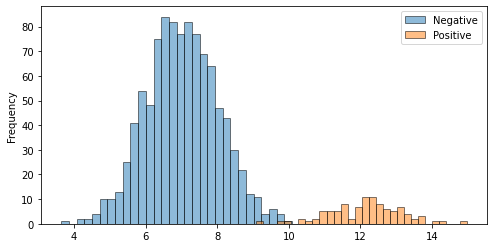

In [2]:
pos_center = 12
pos_count = 100
neg_center = 7
neg_count = 1000
rs = rn.RandomState(rn.MT19937(rn.SeedSequence(42)))
gini = pd.DataFrame({'value':
np.append((pos_center) + rs.randn(pos_count),
(neg_center) + rs.randn(neg_count)),
'label':
['pos']* pos_count + ['neg'] * neg_count})
fig, ax = plt.subplots(figsize=(8, 4))
_ = (gini
.groupby('label')
[['value']]
.plot.hist(bins=30, alpha=.5, ax=ax, edgecolor='black')
)
_= ax.legend(['Negative', 'Positive'])

In the graph displayed above, there is an overlap between 9 and 10 of the negative and positive. How do we find an algorithm that determines whether values are negative or positive? The Gini coefficient could be used to help us with that task. Below is a function to help us with that.

In [3]:
def calc_gini(df, val_col, label_col, pos_val, split_point, debug=False):
    """
    This function calculates the Gini impurity of a dataset. Gini impurity
    is a measure of the probability of a random sample being classified
    incorrectly when a feature is used to split the data. The lower the
    impurity, the better the split.
    Parameters:
    df (pd.DataFrame): The dataframe containing the data
    val_col (str): The column name of the feature used to split the data
    label_col (str): The column name of the target variable
    pos_val (str or int): The value of the target variable that represents
    the positive class
    split_point (float): The threshold used to split the data.
    debug (bool): optional, when set to True, prints the calculated Gini
    impurities and the final weighted average
    Returns:
    float: The weighted average of Gini impurity for the positive and
    negative subsets.
    """
    
    ge_split = df[val_col] >= split_point
    eq_pos = df[label_col] == pos_val
    tp = df[ge_split & eq_pos].shape[0]
    fp = df[ge_split & ~eq_pos].shape[0]
    tn = df[~ge_split & ~eq_pos].shape[0]
    fn = df[~ge_split & eq_pos].shape[0]
    pos_size = tp+fp
    neg_size = tn+fn
    total_size = len(df)
    if pos_size == 0:
        gini_pos = 0
    else:
        gini_pos = 1 - (tp/pos_size)**2 - (fp/pos_size)**2
    if neg_size == 0:
        gini_neg = 0
    else:
        gini_neg = 1 - (tn/neg_size)**2 - (fn/neg_size)**2
    weighted_avg = gini_pos * (pos_size/total_size) + gini_neg * (neg_size/total_size)

    if debug:
        print(f'{gini_pos=:.3} {gini_neg=:.3} {weighted_avg=:.3}')
    return weighted_avg

calc_gini(gini, val_col='value', label_col='label', pos_val='pos',split_point=9.24, debug=True)

gini_pos=0.217 gini_neg=0.00202 weighted_avg=0.0241


0.024117224644432264

Text(0.5, 0, 'Split Point')

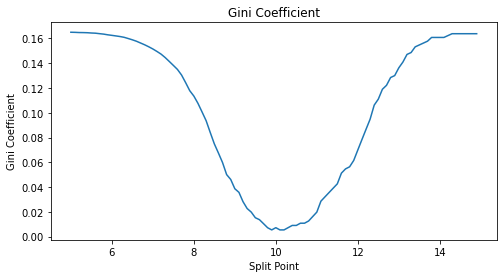

In [4]:
values = np.arange(5, 15, .1)
ginis = []
for v in values:
    ginis.append(calc_gini(gini, 
                           val_col='value', label_col='label', 
                           pos_val='pos', split_point=v))
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(values, ginis)
ax.set_title('Gini Coefficient')
ax.set_ylabel('Gini Coefficient')
ax.set_xlabel('Split Point')

The lowest Gini coeeficient lies around 10. We want to check those values.

In [5]:
pd.Series(ginis, index=values).loc[9.5:10.5]

9.6     0.013703
9.7     0.010470
9.8     0.007193
9.9     0.005429
10.0    0.007238
10.1    0.005438
10.2    0.005438
10.3    0.007244
10.4    0.009046
10.5    0.009046
dtype: float64

From the above we can see that the split point of 9.9 will maximize this coefficient

In [6]:
print(pd.DataFrame({'gini':ginis, 'split':values})
      .query('gini <= gini.min()')
     )

        gini  split
49  0.005429    9.9


## 4.2 Coefficients in Trees

We want to create a decision stump (or a decision tree without branches)

In [7]:
from sklearn import tree
stump = tree.DecisionTreeClassifier(max_depth=1)
stump.fit(gini[['value']], gini.label)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'value <= 9.708\ngini = 0.165\nsamples = 1100\nvalue = [1000, 100]\nclass = neg'),
 Text(0.25, 0.25, 'gini = 0.002\nsamples = 999\nvalue = [998, 1]\nclass = neg'),
 Text(0.75, 0.25, 'gini = 0.039\nsamples = 101\nvalue = [2, 99]\nclass = pos')]

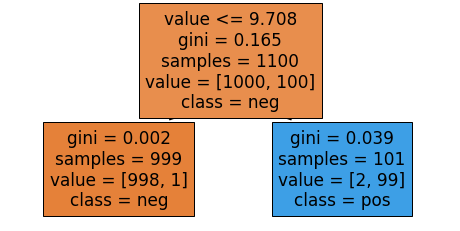

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
tree.plot_tree(stump, feature_names=['value']
               ,filled=True,class_names=stump.classes_
               ,ax=ax)

In [9]:
gini_pos = 0.039
gini_neg = 0.002
pos_size = 101
neg_size = 999
total_size = pos_size + neg_size
weighted_avg = gini_pos * (pos_size/total_size) + gini_neg * (neg_size/total_size)
print(weighted_avg)

0.005397272727272727


XGBoost goes through a tree-building process. After training a tree, there are two statistics _gi_ and _hi_. They are similar to
Gini but also represent the behavior of the loss function. The gradient (_gi_) represents the first
derivative of the loss function with respect to the predicted value for each instance, while the
second derivative (_hi_) represents the curvature of the loss function.

To create a stump in XGBoost, we limit the _max_depth_ and _n_estimators_ parameters

In [10]:
import xgboost as xgb
xg_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)
xg_stump.fit(gini[['value']], (gini.label== 'pos'))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

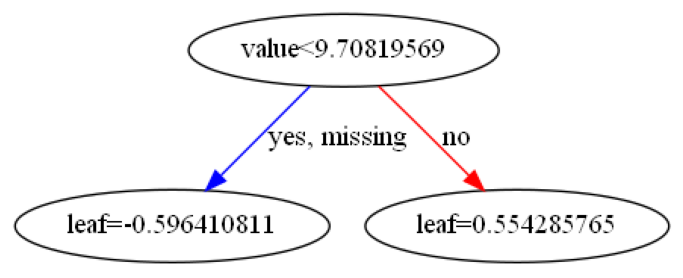

In [11]:
import os
# create a new directory called "img" if it does not exist
if not os.path.exists('img'):
    os.makedirs('img')
    
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_tree(xg_stump, num_trees=0, ax=ax)
plt.savefig('img/stump_xg.png')

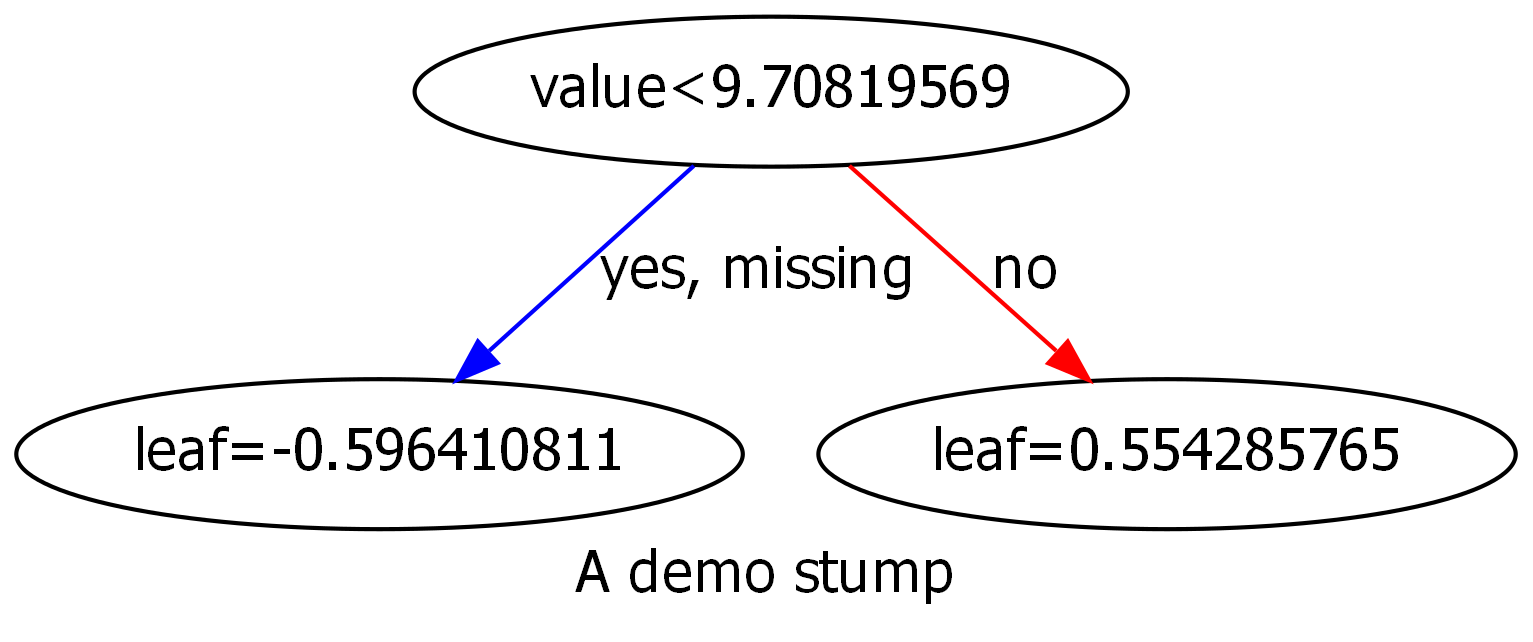

In [12]:
my_image_export(xg_stump, n_trees=0, filename='img/stump_xg.dot', title='A demo stump')

In [13]:
import subprocess
def my_dot_export(xg, num_trees, filename, title='', direction='TB'):
    """Exports a specified number of trees from an XGBoost model as a graph
    visualization in dot and png formats.
    Args:
    xg: An XGBoost model.
    num_trees: The number of tree to export.
    filename: The name of the file to save the exported visualization.
    title: The title to display on the graph visualization (optional).
    direction: The direction to lay out the graph, either 'TB' (top to
    bottom) or 'LR' (left to right) (optional).
    """
    res = xgb.to_graphviz(xg, num_trees=num_trees)
    content = f''' node [fontname = "Roboto Condensed"];
    edge [fontname = "Roboto Thin"];
    label = "{title}"
    fontname = "Roboto Condensed"
    '''
    out = res.source.replace('graph [ rankdir=TB ]',
                             f'graph [ rankdir={direction} ];\n {content}')
    # dot -Gdpi=300 -Tpng -ocourseflow.png courseflow.dot
    dot_filename = filename
    with open(dot_filename, 'w') as f:
        f.write(out)
    png_filename = dot_filename.replace('.dot', '.png')
    subprocess.run(f'dot -Gdpi=300 -Tpng -o{png_filename} {dot_filename}'.split())
    
    
#my_dot_export(xg_stump, num_trees=0, filename='img/stump_xg.dot', title='A demo stump')

## 4.3 Another Visualization Tool
This is a Python library for visualizing decision trees. It provides an easy-to-use interface for creating and customizing decision tree visualizations with a range of options for tree layout, node formatting, and color schemes. 

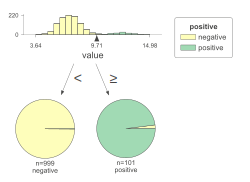

In [14]:
import dtreeviz
viz = dtreeviz.model(xg_stump, X_train=gini[['value']], 
                     y_train=gini.label=='pos', 
                     target_name='positive',
                     feature_names=['value'], class_names=['negative', 'positive'],
                     tree_index=0)
viz.view()

In [15]:
graph = xgb.to_graphviz(xg_stump, num_trees=0)
graph.render('img/stump_xg', format='dot')

'img\\stump_xg.dot'

In [16]:
my_dot_export(xg_stump, num_trees=0, filename='img/stump_xg.dot', title='A demo stump')

```python
import subprocess
def my_dot_export(xg, num_trees, filename, title='', direction='TB'):
    """Exports a specified number of trees from an XGBoost model as a graph
    visualization in dot and png formats.
    Args:
    xg: An XGBoost model.
    num_trees: The number of tree to export.
    filename: The name of the file to save the exported visualization.
    title: The title to display on the graph visualization (optional).
    direction: The direction to lay out the graph, either 'TB' (top to
    bottom) or 'LR' (left to right) (optional).
    """
    res = xgb.to_graphviz(xg, num_trees=num_trees)
    content = f''' node [fontname = "Roboto Condensed"];
    edge [fontname = "Roboto Thin"];
    label = "{title}"
    fontname = "Roboto Condensed"
    '''
    out = res.source.replace('graph [ rankdir=TB ]',
                             f'graph [ rankdir={direction} ];\n {content}')
    # dot -Gdpi=300 -Tpng -ocourseflow.png courseflow.dot
    dot_filename = filename
    with open(dot_filename, 'w') as f:
        f.write(out)
    png_filename = dot_filename.replace('.dot', '.png')
    subprocess.run(f'dot -Gdpi=300 -Tpng -o{png_filename} {dot_filename}'.split())
```

The `subprocess` module allows you to spawn new processes, connect to their input/output/error pipes, and obtain their return codes.

```python
def my_dot_export(xg, num_trees, filename, title='', direction='TB'):
    """
    Exports a specified number of trees from an XGBoost model as a graph visualization in dot and png formats.

    Args:
    xg: An XGBoost model.
    num_trees: The number of tree to export.
    filename: The name of the file to save the exported visualization.
    title: The title to display on the graph visualization (optional).
    direction: The direction to lay out the graph, either 'TB' (top to bottom) or 'LR' (left to right) (optional).
    """

    res = xgb.to_graphviz(xg, num_trees=num_trees)
```

This function `my_dot_export` takes an XGBoost model, a number of trees to export, a filename to save the exported visualization, an optional title, and an optional direction for the graph layout as input.

It then uses `xgb.to_graphviz` to generate the graph visualization in the DOT format, given the number of trees to export.

```python
content = f''' node [fontname = "Roboto Condensed"];
edge [fontname = "Roboto Thin"];
label = "{title}"
fontname = "Roboto Condensed"
'''
out = res.source.replace('graph [ rankdir=TB ]',f'graph [ rankdir={direction} ];\n {content}')
```
This block of code sets up the content and styling of the exported visualization, including the font typeface and title.

The `DOT` output from `xgb.to_graphviz` is then modified by replacing the default layout `TB` with the specified layout `direction`, and appending the content and styling setup.

```python
dot_filename = filename
with open(dot_filename, 'w') as f:
    f.write(out)
png_filename = dot_filename.replace('.dot', '.png')
subprocess.run(f'dot -Gdpi=300 -Tpng -o{png_filename} {dot_filename}'.split())
```
This block of code saves the modified `DOT` output to a file with the specified filename.

It then uses the s`ubprocess` module to run the Graphviz `dot` command to convert the DOT file to a PNG image, which is saved with the same name as the DOT file but with a `.png` extension.

Overall, this function generates a graph visualization of the specified number of trees from an XGBoost model in the DOT format, and saves it as both a DOT and PNG file.